100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.74it/s]


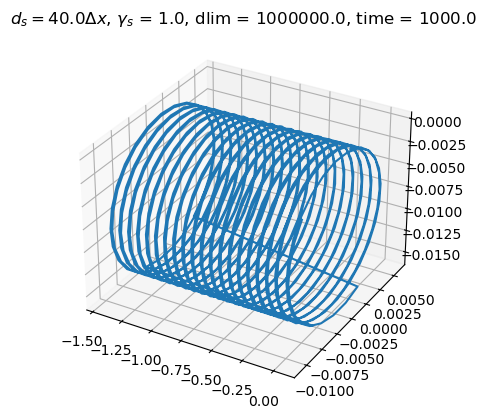

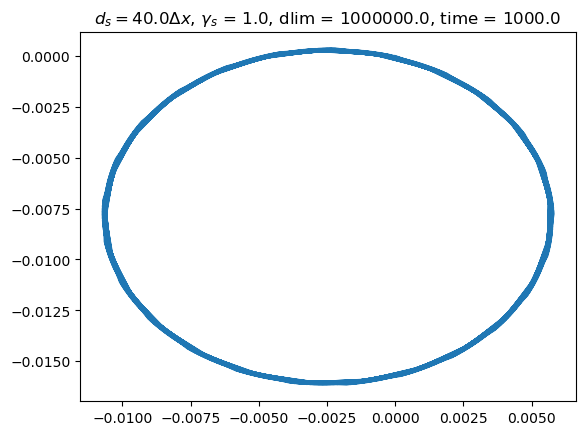

In [51]:
import numpy as np
import scipy as sp
from pydmd import DMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import hankel_preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tristanVis.isolde as isolde
from tqdm import tqdm
out_dir = "../output/"

"""
Typical stuff read from the input and history file, and needed for analysis
"""
input_file_name = "../inputs/inputAG.gyro_test"
hist            = isolde.parseHistory("../output/history")
input_params    = isolde.parseInput(input_file_name)
interval        = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
shift_gamma     = input_params["problem"]["shift_gamma"]
gamma_syn       = input_params["radiation"]["gamma_syn"]
d_lim           = input_params["radiation"]["dens_limit"]
grid_x          = int(input_params["grid"]["mx0"])
grid_y          = int(input_params["grid"]["my0"])
grid_z          = int(input_params["grid"]["mz0"])
Nsteps          = int(lst_time// interval)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
omegap0         = CC / COMP
time            = hist["time"] * omegap0
"""
A WORD FROM ANINDYA (2/6/2024) ABOUT UNITS !!
#############################################

In my experience with Tristan code units, its most convenient to use dimensionless units of time and space.
Set code time steps and space steps to 1 (like, mentally : you don't have to do anything).
dt = 1
dx = 1

Then omegap0 is the plasma frequency in this units = CC / COMP dt^-1 = CC/COMP
And Debye length / skin-depth, d_e = COMP dx = COMP.

If (x,t) is (space,time) in code units then use the dimensionless (x/d_e, omegap0 * t) for all physics expressions/ theory.

BTW, in these units defined as such speed of light is c = CC dx/dt = CC.
"""

def fetch_var_at_step(out_dir, var, step):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        return(isolde.getParticles(filename))
    elif var == "flds":
        return(isolde.getFields(filename))
    else:
        print("Not supported yet!")
        return False

"""
TEMPLATES to fetch density, electric field and particle positions / velocities
##############################################################################

# density = np.zeros(shape = (2, Nsteps,grid_x))
# for step in range(Nsteps):
#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]

# Ex = np.zeros(shape = (Nsteps,grid_x))
# for step in range(Nsteps):
#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]

# X1 = []
# ux_1 = []
# X2 = []
# ux_2 = []
# for step in tqdm(range(Nsteps)):    
#     X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
#     ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
#     X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
#     ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
# X1=np.array(X1)
# ux_1 = np.array(ux_1)
# X2=np.array(X2)
# ux_2 = np.array(ux_2)
"""

X1   = []
Y1   = []
Z1   = []
ux_1 = []
uy_1 = []
uz_1 = []


for step in tqdm(range(Nsteps)):    
    X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
    ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
    Y1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['y'])
    uy_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['v'])
    Z1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['z'])
    uz_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['w'])
    
X1   = np.array(X1)
ux_1 = np.array(ux_1)
Y1   = np.array(Y1)
uy_1 = np.array(uy_1)
Z1   = np.array(Z1)
uz_1 = np.array(uz_1)

fig = plt.figure()
ax = plt.axes(projection ='3d')

start_step = 0
stop_step = -1

sc_X1 = (X1 - X1[start_step,0])/COMP
sc_Y1 = (Y1 - Y1[start_step,0])/COMP
sc_Z1 = (Z1 - Z1[start_step,0])/COMP

ax.plot3D(sc_X1[start_step: stop_step,0], sc_Y1[start_step: stop_step,0], sc_Z1[start_step: stop_step,0])
ax.set_title(r"$d_s = {} \Delta x$, $\gamma_s$ = {}, dlim = {}, time = {}".format(COMP, gamma_syn, d_lim, lst_time))

fig2, ax2 = plt.subplots()
ax2.set_title(r"$d_s = {} \Delta x$, $\gamma_s$ = {}, dlim = {}, time = {}".format(COMP, gamma_syn, d_lim, lst_time))

plt.plot(sc_Y1[start_step: stop_step,0], sc_Z1[start_step: stop_step,0])
plt.savefig("./gyro_pics/d_s = {} dx$, gamma_syn = {}, dlim = {}, time = {}.png".format(COMP, gamma_syn, d_lim, lst_time))


100%|██████████████████████████████████████████████████████████████████████████████▉| 2499/2500 [03:43<00:00, 11.19it/s]

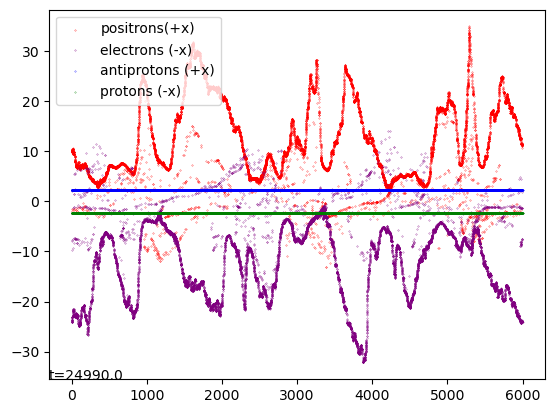

100%|██████████████████████████████████████████████████████████████████████████████▉| 2499/2500 [03:55<00:00, 11.19it/s]

In [33]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is for animating the phase space and show the "eye"-formation.
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots()


# Function to update the frame
def animate_phase(frame):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    ax.scatter(X1[frame, :], ux_1[frame, :], s = 0.05, color = "red", label="positrons(+x)")
    ax.scatter(X2[frame, :], ux_2[frame, :], s = 0.05, color = "purple", label="electrons (-x)") 
    ax.scatter(X3[frame, :], ux_3[frame, :], s = 0.05, color = "blue", label="antiprotons (+x)")
    ax.scatter(X4[frame, :], ux_4[frame, :], s = 0.05, color = "green", label="protons (-x)") 
    ax.text(0, 0, "t=" + str(frame * interval), fontsize=10, transform=ax.transAxes)
    ax.legend(loc="upper left")
    return ax.lines + [ax.texts[-1]]  # Return a list of Artists

# Create the animation
ani = FuncAnimation(fig, animate_phase, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=30, bitrate=1800)
ani.save("../vault_out/cold_plasma_sims/phase_space_gamma_{:.3f}_test_13_cold.mp4".format(shift_gamma), writer=writer, dpi=300)

plt.show()

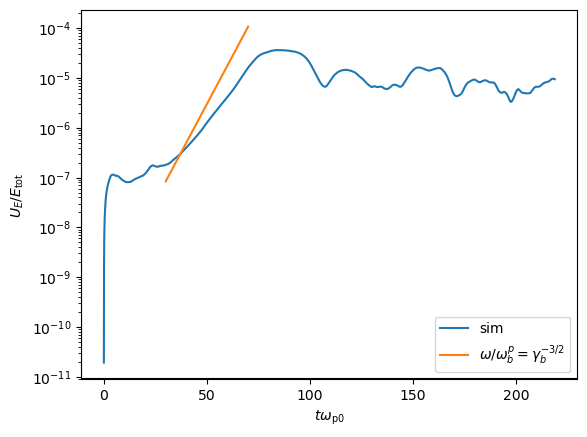

In [36]:
fig, ax = plt.subplots()
hist = isolde.parseHistory("../output/history")
omegap0 = CC / COMP
rate = 0.5 * (0.5) ** 0.5 / shift_gamma ** (1.5)
time = hist["time"] * omegap0
E2 = (hist["Ex^2"] + hist["Ey^2"])/ hist["Etot"][0]
ax.plot(time, E2, label="sim")
xs = np.linspace(30, 70, 10)
ys = np.exp(2 * rate * xs)
ys = (E2[time > 10][0]) * (ys / ys[0])
ax.plot(xs, ys, label=r"$\omega/\omega_{b}^p=\gamma_b^{-3/2}$")
#ax.set_ylim(1e-4, 1e-1)
#ax.set_xlim(0, 40)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
ax.set_ylabel(r"$U_E / E_{\rm tot}$")
ax.axvline(ax.get_xlim()[0], color="black")
ax.axhline(ax.get_ylim()[0], color="black")
# ax.text(
#      10,
#      0.6e-8,
#      r"""
#      energy conservation
#      by $t\omega_{{\rm p 0}}={{{}}}: \Delta E/E={{{}}}\%$
#      """.format(
#          int(hist["time"][-1] * omegap0),
#          int(hist["% dEtot"][-1] * 10000) / 10000,
#      ),
# )

plt.legend()

plt.show()

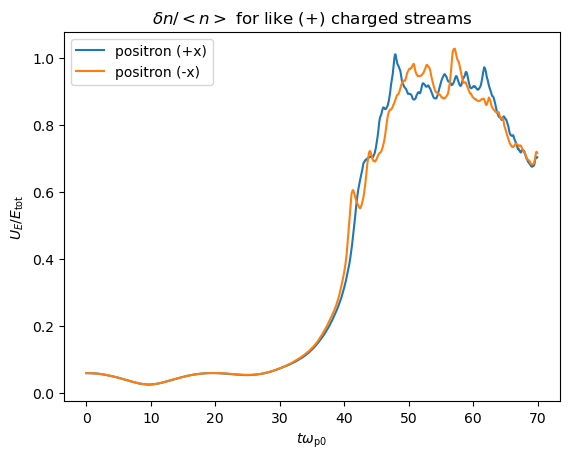

In [51]:
delta_d1 = np.std(density1, axis = 1)
delta_d2 = np.std(density2, axis = 1)

mean_d1  = np.mean(density1, axis = 1)
mean_d2  = np.mean(density2, axis = 1)

T =np.arange(mean_d1.shape[0]) * interval * omegap0
fig, ax = plt.subplots()
ax.plot(T, delta_d1/mean_d1, label = "positron (+x)")
ax.plot(T, delta_d2/mean_d2, label = "positron (-x)")
ax.set_title(r"$\delta n / <n>$ for like (+) charged streams")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
ax.set_ylabel(r"$U_E / E_{\rm tot}$")
plt.legend()

Gamma = 1.800
growth rate (dimensionless) =  0.1989406019579093
Discrepency = -2.378424891828636%
Peak k-mode = 1.0053096491487339
Gamma = 1.900
growth rate (dimensionless) =  0.20220283336602043
Discrepency = 0.14657605158686096%
Peak k-mode = 1.0053096491487339
Gamma = 2.000
growth rate (dimensionless) =  0.19722113952566384
Discrepency = 1.9756249759212672%
Peak k-mode = 1.0053096491487339
Gamma = 2.100
growth rate (dimensionless) =  0.1879829877118143
Discrepency = 3.0315629020190116%
Peak k-mode = 1.0053096491487339
Gamma = 2.200
growth rate (dimensionless) =  0.17731899142437926
Discrepency = 3.5833854074472313%
Peak k-mode = 1.0053096491487339
Gamma = 2.300
growth rate (dimensionless) =  0.16688815773912438
Discrepency = 3.905711384922851%
Peak k-mode = 1.0053096491487339
Gamma = 2.400
growth rate (dimensionless) =  0.1574371418282577
Discrepency = 4.11986895690657%
Peak k-mode = 1.0053096491487339
Gamma = 2.500
growth rate (dimensionless) =  0.14911062949607345
Discrepency = 4.

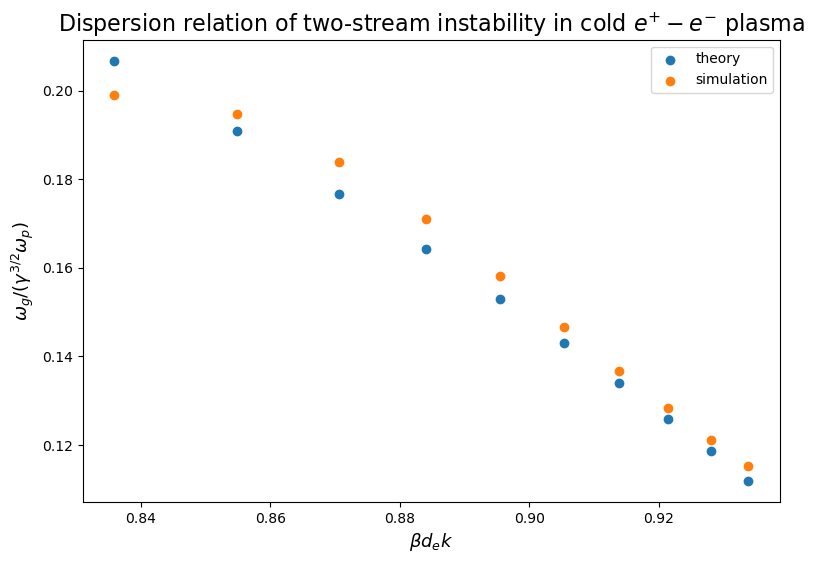

In [79]:
import warnings
warnings.filterwarnings("ignore") #DMD does not like the size of data, but those warnings are not critical.

#Extracting parameters from input file
input_params = isolde.parseInput(input_file_name)
interval = input_params["output"]["interval"]
lst_time = input_params["time"]["last"]
grid_x = int(input_params["grid"]["mx0"])
Nsteps = int(lst_time // interval)

ShiftGamma = np.linspace(1.8, 2.7, 10)

g_ex = np.zeros_like(ShiftGamma)
g_ex_lin = np.zeros_like(ShiftGamma)
k_ex = np.zeros_like(ShiftGamma)

for i in range(ShiftGamma.shape[0]):
    #Extracting data from the correct output folder in the "vault_out"
    out_dir = "./vault_out/output_ARCH_gamma_{:.3f}_int_{}/".format(ShiftGamma[i], interval)

    #Assuming dt =1, this is the non-relativistic plasma frequency
    omegap0 = input_params["algorithm"]["c"] / input_params["plasma"]["c_omp"]

    #Electric field data, I don't use the density as it seems to globally decrease (I don't know why yet)
    Ex = np.zeros(shape = (Nsteps,grid_x)) 
    for step in range(Nsteps):
        Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]
    
    #These often need tweaking (These are final, dont change!)
    # start = 575
    # end = 875
    # D = 200
    #These are indices (NOT simulation time! : that will be interval*indices)
    start = 575 
    end = 875
    D = 200 #Delay for hankel preprocessing
    
    print("Gamma = {:.3f}".format(ShiftGamma[i]))

    #Using electric field data upto 2000 dx
    data = Ex[start:end, 0:2000]**2
    data = data/data[0,0]  
    
    #Setting up dynamic mode decomposition!    
    svd_rank = 1 #Only 1st principle component is used, as we only care about the dominant growing mode
    dmd = DMD(svd_rank=svd_rank)    
    delay_dmd = hankel_preprocessing(dmd, d=D)
    delay_dmd.fit(data.T)

    #This is the way we need the growthrates, because pyDMD gives "delay_dmd.eigs.real" which is wrong!
    growth_rates = np.log(delay_dmd.eigs).real / (delay_dmd.original_time["dt"])     
    modes = delay_dmd.modes
    
    #Max observed growth rate (index). Although I have only 1 mode, this is provisional!
    gmax = np.argmax(growth_rates)    
    print("growth rate (dimensionless) = ", growth_rates[gmax]/omegap0)

    #A way to sanity check: does the dmd growthrate match the average growth of E-field energy within ~5% ?
    dmd_growth = np.exp(growth_rates[gmax] * (end-start))
    actual_growth = np.sum(data[-1, :])/ np.sum(data[0, :])
    print("Discrepency = {}%".format((dmd_growth - actual_growth)/actual_growth * 100)) #Should be ~<5%
    
    #Growth rate in dimensionless units of \omega_p0 (adjusted by the interval i.e. sampling period of output)
    g_ex[i] = growth_rates[gmax]/(omegap0 * interval)
    #A backup growth rate found from the slope of a fitted straight line to the logarithm of the data.
    g_ex_lin[i], _ = np.polyfit(np.arange(start, end, 1)*omegap0, np.log(np.sum(data[:, :], axis = 1)), 1)
    
    #Extracting max growing spatial mode
    mode_gmax = modes.T[gmax]    
    N =  mode_gmax.shape[0]//D

    #Actual spatial mode needs to be estimated from this mode vector. It looks like rescaled D copies to me.
    #So, I fold all the copies into one to get an estimate of the spatial mode.
    mode_folded = np.zeros(shape = (N,), dtype = 'complex128')
    for j in range(D):
        mode_folded += mode_gmax[j*N : (j+1)*N]
    mode_folded /= D

    #Sampling frequency of position in dimensionless units: d_e = COMP dx -> d_e / dx = COMP
    fxs = input_params["plasma"]["c_omp"]

    #Standard FFT to get the spectrum and hence the peak spatial wavenumber.
    f_x, spec_x = sp.signal.periodogram(mode_folded.real, fxs, scaling = "spectrum")
    k_x_max = 2*np.pi*f_x[spec_x.tolist().index(max(spec_x))]    
    print("Peak k-mode = {}".format(k_x_max))
    k_ex[i] = k_x_max


# COMPARISON WITH THEORY

#Theoretical growth rates for the measures wavenumber and gamma
Beta = np.sqrt(1 - 1/ShiftGamma**2)
w_d = Beta * k_ex
g_th = np.sqrt(-(1 + w_d**2 - np.sqrt(1 + 4*w_d**2)))/ShiftGamma**1.5

#Plotting the dispersion relation! (theory and simulation)
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(w_d[:], g_th[:], label = "theory")
ax.scatter(w_d[:], g_ex_lin[:], label = "simulation")
ax.set_xlabel(r"$\beta d_e k$", fontsize = 13)
ax.set_ylabel(r"$\omega_g/ (\gamma^{3/2}\omega_p)$", fontsize = 13)
ax.set_title(r"Dispersion relation of two-stream instability in cold $e^{+}-e^{-}$ plasma", fontsize = 16)
plt.legend()
plt.show()

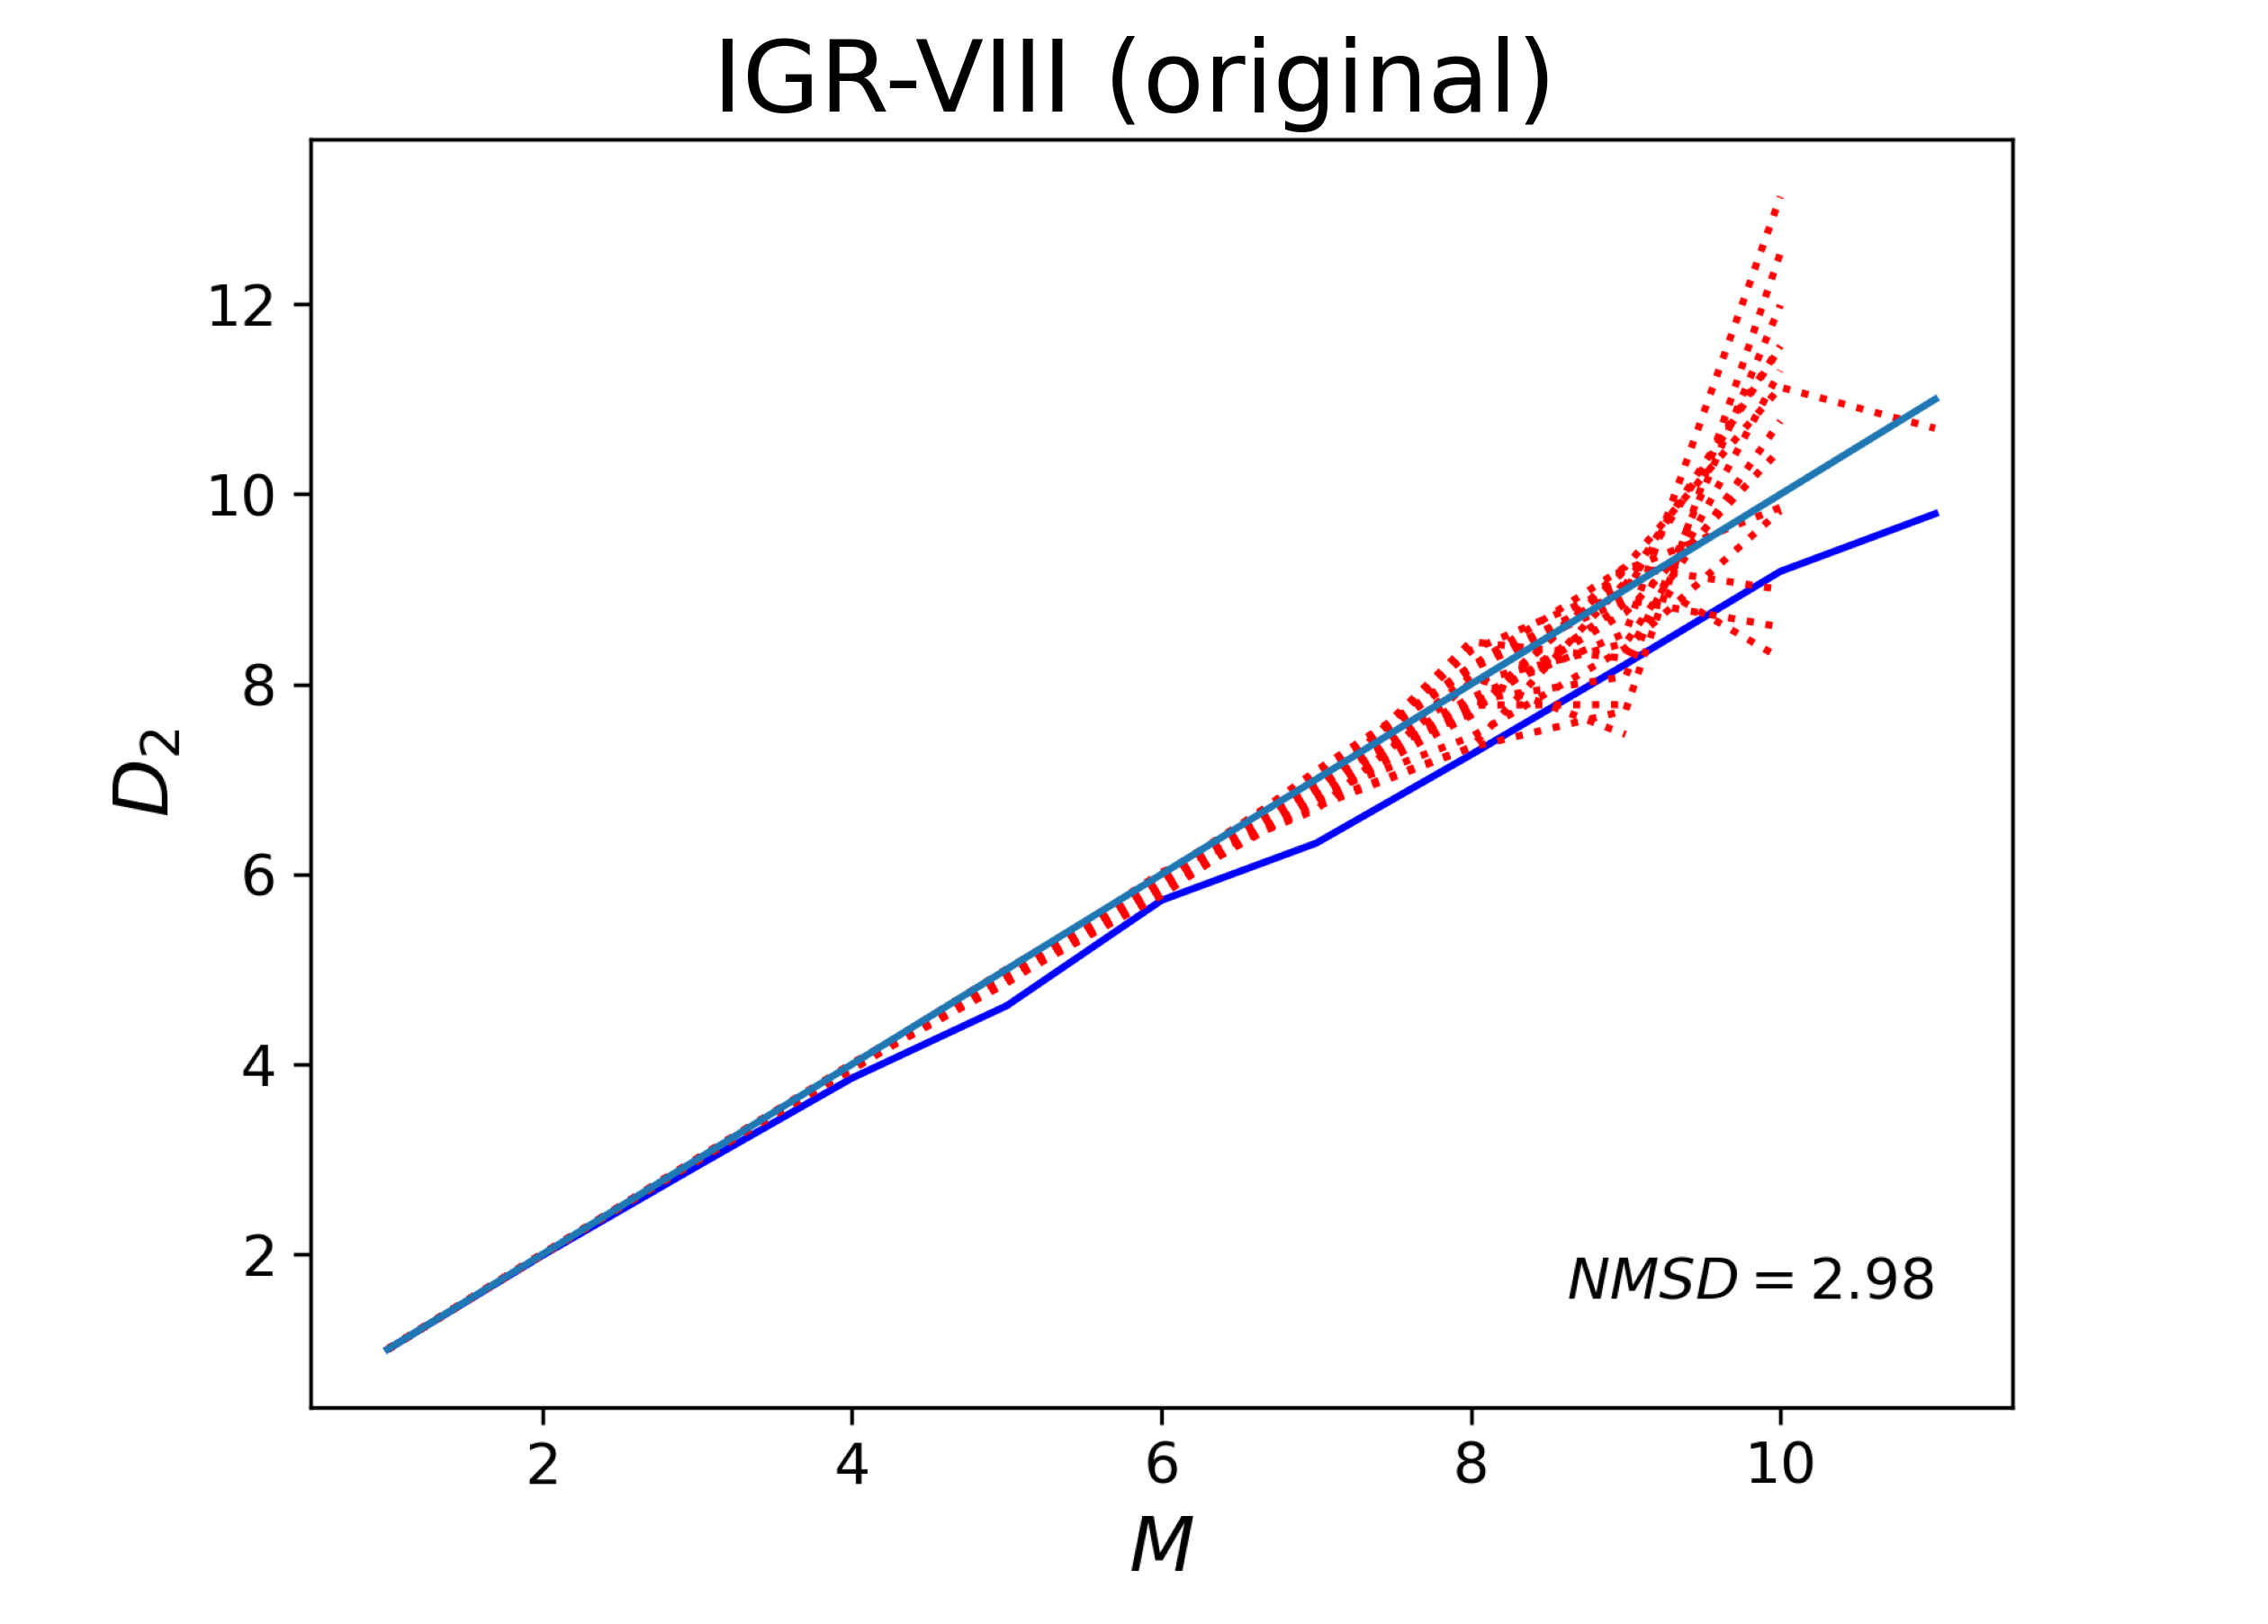

Image saved to ./Bani_project/IGR/ORG_cd_igr_8_v2.png


In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg
import io

def edit_image_title(input_path, new_title, crop_top=100, title_height=120):
    # Read the image
    img = mpimg.imread(input_path)
    
    # Crop the top part of the image to remove the old title
    img_cropped = img[crop_top:, :, :]
    
    # Create a new figure with the same size as the original image plus title space
    fig, ax = plt.subplots(figsize=(img.shape[1]/300, (img.shape[0]+title_height)/300), dpi=400)
    
    # Remove axes
    ax.axis('off')
    
    # Display the cropped image
    ax.imshow(img_cropped)
    
    # Add the new title
    plt.title(new_title, fontsize = 20, pad=title_height/2)
    
    # Adjust the layout to make room for the title
    plt.tight_layout()
    

    
    # # Ask if the user wants to save the image
    # save_choice = 'y'#input("Do you want to save this image? (y/n): ").lower()
    
    # if save_choice == 'y':
    save_path = input_path[:-4] + "_v2.png"#"./Bani_project/IGR/BOX_cd_igr_1_v2.png"#input("Enter the path to save the image: ")
    plt.savefig(save_path, dpi = 400)
    # Show the plot
    plt.show()
    print(f"Image saved to {save_path}")
    # else:
    #     print("Image not saved.")


# Usage
input_path = "./Bani_project/IGR/ORG_cd_igr_8.png"
new_title = 'IGR-VIII (original)'
edit_image_title(input_path, new_title, crop_top = 170, title_height = 10)
